In [191]:
import pandas as pd
import numpy 
from sklearn import metrics 
import matplotlib.pyplot as plt 
import numpy as np
import pickle
from matplotlib.pyplot import figure

In [98]:
import warnings
warnings.filterwarnings("ignore")

In [160]:
cit=pd.read_csv("YeastbothresultsCIT10k.csv")

In [161]:
nlmr=pd.read_csv("YeastbothresultsOurmethod10k.csv")

In [162]:
cit=cit.sort_values('p_cit')

In [163]:
nlmr=nlmr.sort_values('p_cit')

In [164]:
nlmr

,p_cit,p_LA,p_LB,diff_test,GroundTruth
5925,0.0,0.0,0.00,0.0,1
3508,0.0,0.0,0.00,0.0,1
14152,0.0,0.0,0.00,0.0,0
6438,0.0,0.0,0.00,0.0,1
3284,0.0,0.0,0.00,0.0,1
...,...,...,...,...,...
2219,1.0,0.0,0.54,1.0,1
2218,1.0,0.0,0.74,1.0,1
2217,1.0,0.0,0.51,1.0,1
12454,1.0,0.0,0.65,1.0,0


In [147]:
top200=nlmr.head(n=200)

In [38]:
true_labels=top200['GroundTruth']
pred_labels=top200['call']

In [34]:
confusion_matrix=metrics.confusion_matrix(top200['GroundTruth'],top200['call'])

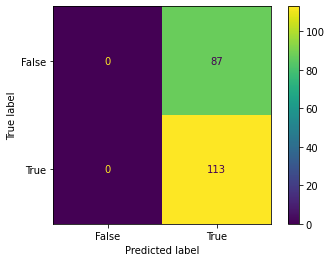

In [37]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

In [105]:
#taking the unique values of the final p values 
#uniquevalues=top200.p_cit.unique()

In [114]:
def compute_table(df,cutoff_range):
    dic={'cutoff':[],'TP':[],'TN':[],'FP':[],'FN':[],'Precision':[],'Recall':[]}

    #cutoff_range=[0.01,0.05,0.10,0.2]
    for cutoff in cutoff_range:
        df['call']=df.apply (lambda row: 1 if row[0] <=cutoff   else 0, axis=1)
        true_labels=df['GroundTruth']
        pred_labels=df['call']

        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

        # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

        # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

        # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
        
        #Precision
        P= TP/(TP+FP)
        #Recall
        R= TP/(TP+FN)
        dic['cutoff'].append(cutoff)
        dic['TP'].append(TP)
        dic['TN'].append(TN)
        dic['FP'].append(FP)
        dic['FN'].append(FN)
        dic['Precision'].append(P)
        dic['Recall'].append(R)
    a=pd.DataFrame(dic)
    return a
    

In [122]:
def calculate_aupr(precision,recall):
    zipped=zip(precision,recall)
    z=sorted(zipped, key = lambda t: t[1])
    precision,recall=zip(*z)
    return metrics.auc(recall,precision)

In [136]:
def computefortopk(data,k):
    
    topk=data.head(n= 20000*k)
    uniquevalues=topk.p_cit.unique()
    table=compute_table(topk,uniquevalues)
    aupr=calculate_aupr(table['Precision'],table['Recall'])
    return aupr

In [137]:
def computefortopk_range(data,values):
    aupr_range=[]
    for i in values:
        aupr_range.append(computefortopk(data,i))
    return aupr_range

In [198]:
top_k=[0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [199]:
aupr_nlmr=computefortopk_range(nlmr,top_k)

In [200]:
aupr_cit=computefortopk_range(cit,top_k)

In [201]:
with open('aupr_nlmr.pkl', 'wb') as file:
      
    pickle.dump(aupr_nlmr, file)
file.close()

In [202]:
with open('aupr_cit.pkl', 'wb') as file:
      
    pickle.dump(aupr_cit, file)
file.close()

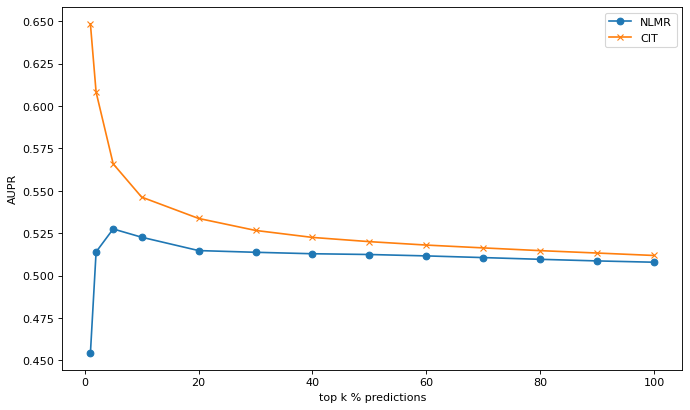

In [203]:
figure(figsize=(10, 6), dpi=80)
plt.plot([i*100 for i in top_k],aupr_nlmr,marker='o',label="NLMR")

plt.plot([i*100 for i in top_k],aupr_cit,marker='x',label="CIT")#plt.plot(aupr_cit,top_k)
plt.xlabel("top k % predictions")
plt.ylabel("AUPR")
#plt.xticks([i*100 for i in top_k],rotation=90)
plt.legend()
plt.show()